In [73]:
# Python imports.

# Import the SOME/IP entities.
from timing.entities import *
# Import the timing analysis functions.
import timing.timing_analysis as analysis_our
import timing.timing_analysis_ssg15 as analysis_ssg15
# Import the plot functions.
from plot.client_service_plot import *
from plot.support import *
import logging
# Set the logging level.
analysis_our.set_logger_level(logging.ERROR)
analysis_ssg15.set_logger_level(logging.ERROR)

# 1 - Estimating the SOME/IP discovery latency
This section estimates the discovery latency for a single client/service pair, where the objective is for the client to discover the desired service.
Typical scenarios have several services and clients, and the following analysis is a necessary step for handling those scenarios.
The idea is that once we compute the discovery time for each client/service pair of the system, the maximum among those values represents the discovery time of our entire system.
In the equations used in this section, we will use $c$ to identify the properties of a *client*, $s$ to identify those of a *service*, and $e$ to identify those of a generic *entity*, which can be either be a  *client* or a *service*.

Let us now define two variables:
<a id="eq1">
\begin{equation}\tag{1}
    c_{init} = c_{\mathit{BootDel}} +  c_{\mathit{InitDel}},
\end{equation}
</a>
<a id="eq2">
\begin{equation}\tag{2}
    s_{init} = s_{\mathit{BootDel}} +  s_{\mathit{InitDel}},
\end{equation}
</a>
where $\mathit{BootDel}$ is the period of time when clients and services are *down*, and $\mathit{InitDel}$ is the length of their *initial wait phase*.
As mentioned above, the delays between messages sent by both client and service during the *repetition phase* is doubled with each consecutive message.
We can compute the delay before sending the $i$-th message using the following:
<a id="eq3">
\begin{equation}\tag{3}
    d(e, i) = 2^{i} \cdot e_{\mathit{RepDel}},
\end{equation}
</a>
where $e_{\mathit{RepDel}}$ represents the repetition delay.
The actual size of the *repetition phase* is given by summing all those delays.
We can compute its size, up to the $n$-th repetition message, by using the following function:
<a id="eq4">
\begin{equation}\tag{4}
    t_{rep}(e, n) = \sum_{i=0}^{n - 1} d(e, i).
\end{equation}
</a>
Using properties of geometric series, we can transform this sum into a single expression:
<a id="eq5">
\begin{equation}\tag{5}
    t_{rep}(e, n) = (2^{n}-1) \cdot e_{\mathit{RepDel}}.
\end{equation}
</a>

## 1.1 - Computing the actual length of the repetition phase
As seen above, the time window when either the client or service starts sending messages is the *repetition phase*.
Depending on their respective configuration, we might end up with a service that enters the *repetition phase* before the client, or the other way around.
For the purpose of timing analysis, we need to compute the index of the first *find* or *offer* message that is able to reach its destination.
To do that, we need to find the timespan in the *repetition phase*, during which the source node (either client or service) sends messages, but the destination node is not ready to receive them.
We can call this timespan the *failure window*.
However, we need to differentiate between two cases: $z_{s}$ if the client enters the *repetition phase* before the service, and $z_{c}$ if the service enters the *repetition phase* before the client.
We can compute them as follows:
<a id="eq6">
\begin{equation}\tag{6}
    z_{s} =
\begin{cases}
    s_{init} - c_{init} & \text{if } s_{init} > c_{init}\\
    0                   & \text{otherwise}
\end{cases},
\end{equation}
</a>
<a id="eq7">
\begin{equation}\tag{7}
    z_{c} =
\begin{cases}
    c_{\mathit{BootDel}} - s_{init} & \text{if } s_{init} < c_{\mathit{BootDel}}\\
    0                      & \text{otherwise}
\end{cases}.
\end{equation}
</a>

We use $c_{\mathit{BootDel}}$ instead of $c_{init}$ to compute $z_{c}$ because the client accepts *offer* messages even during the *initial wait phase*.

Once we have computed the size of the *failure window*, we need to find the index of the first message that is able to reach its destination within the *repetition phase*.
Again, we need to differentiate between $x_s$ for *find* messages, and $x_c$ for *offer* messages.
We can compute these two values as follows:
<a id="eq8">
\begin{equation}\tag{8}
    x_{s} =
    \begin{cases}
         \left\lceil \log_2 \left( \dfrac{z_s - \mathit{t_c}}{c_{\mathit{RepDel}}} + 1 \right) \right\rceil & \text{if } z_s > \mathit{t_c} ,\\
         0 & \text{otherwise}
    \end{cases}
\end{equation}
</a>
<a id="eq9">
\begin{equation}\tag{9}
    x_{c} =
    \begin{cases}
         \left\lceil \log_2 \left( \dfrac{z_c - \mathit{t_c}}{s_{\mathit{RepDel}}} + 1 \right) \right\rceil & \text{if } z_c > \mathit{t_c} ,\\
         0 & \text{otherwise}
    \end{cases}
\end{equation}
</a>
where $\mathit{t_c}$ represents the communication delay between the client/service pair, and $\mathit{RepDel}$ represents the repetition base delay used during the *repetition phase*.

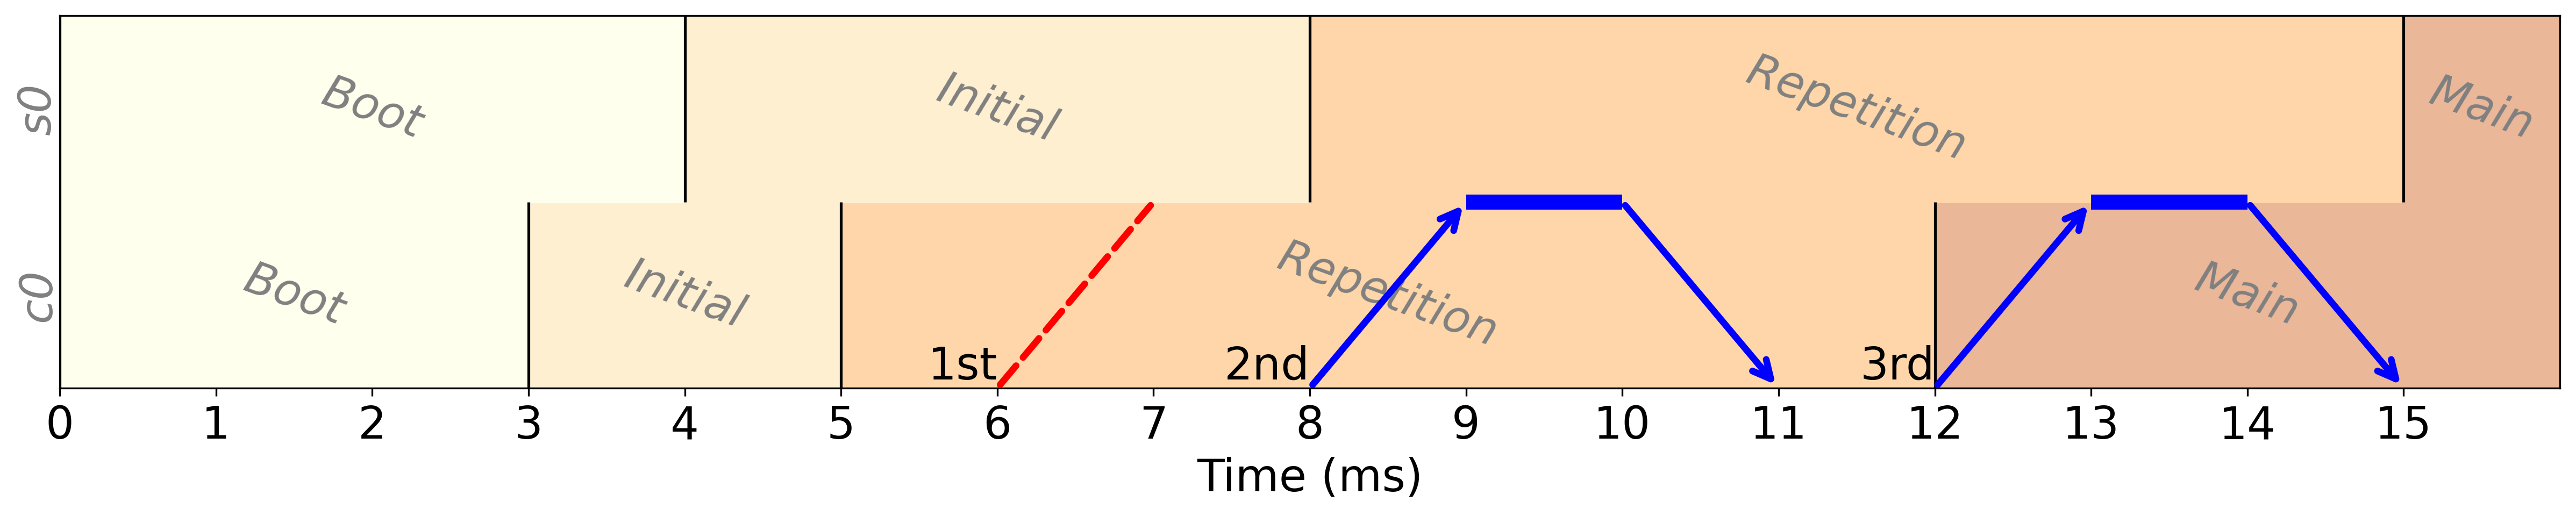

In [74]:
# Figure 1 generation code.
# Service and client configuration.
s = Service("s0", 4, 4, 1, 3, 2, 1, False)
c = Client("c0", 3, 2, 1, 3, True)
# Make a list with the entities.
entities = [c, s]
# Adjust the phases (only to improve visualization).
adjust_phases(entities)
# Communication delay.
t_c = 1
# The actual start-up delay.
t_w_our = analysis_our.timing_analysis(s, c, t_c)
t_w_ssg15 = analysis_ssg15.timing_analysis(s, c, t_c)
# Setup the plot.
[fig, ax] = plot_setup(entities, width=20, height=3, fontsize=20)
# Plot the phases.
plot_all_phases(ax, entities=entities, palette=light_palette)
# Plot service messages.
plot_rep_messages(ax, s, c, t_c, plot_first=False, stop_at_first=False, send_time=False, arrival_time=False, plot_answer=False, plot_index=True)
plot_cyc_messages(ax, s, c, t_c, plot_first=False, stop_at_first=False, send_time=False, arrival_time=False, plot_answer=False, plot_index=True)
plot_rep_messages(ax, c, s, t_c, plot_first=False, stop_at_first=False, send_time=False, arrival_time=False, plot_answer=True, plot_index=True)
plt.show()

<a id="fig1">Figure 1</a>. Example showing the *failure window* (red hatched band in the middle), and *repetition phase* messages that either fail (red dashed line) or succeed (blue arrow) to reach the service.

Let us analyze these two equations with the help of [Figure 1](#fig1).
In this example, $\mathit{t_c}$=$1$, $c_{\mathit{RepDel}}$=$1$, $c_{\mathit{RepMax}}$=$3$, and $z_s$=$3$.
Now, from [Equation (5)](#eq5) we know how to compute the length of the *repetition phase* given that we are sending the $n$-th message.
Conversely, here we want to compute the index of the first message that successfully reaches the destination, after the *failure window*.
As already mentioned, every message sent inside the *failure window* is not received by the destination node.
However, we need to take into account the communication delay $\mathit{t_c}$.
Because, as shown in [Figure 1](#fig1), the message is still delivered if the instant when the message is sent is inside the *failure window*, but the instant when it is received is not, i.e., after $\mathit{t_c}$.
That is why the actual size we need to consider in our equations is $z_s - \mathit{t_c}$.
We can derive [Equation (8)](#eq8) starting from [Equation (5)](#eq5), as follows:
\begin{equation*}
\begin{split}
    t_{rep}(c, x_s) &= z_s - \mathit{t_c},\\
	(2^{x_s} - 1) \cdot c_{\mathit{RepDel}} &= z_s - \mathit{t_c},\\
	2^{x_s} &=  \frac{z_s - \mathit{t_c}}{c_{\mathit{RepDel}}} + 1,\\
	x_s &= \log_2 \left( \frac{z_s - \mathit{t_c}}{c_{\mathit{RepDel}}} + 1 \right) .
\end{split}
\end{equation*}
Computed in this manner, $x_s$ would return a real number, and not the index we would expect.
For instance, if we plug in the values from the scenario shown in [Figure 1](#fig1), the expression would evaluate to $1.58$.
Applying the $ceil$ function, like we do in [Equation (8)](#eq8) and [(9)](#eq9), allow us to compute the actual index of the successfully received message, which in the example is $2$.
We can derive [Equation (9)](#eq9) in a similar manner.

In order to avoid overestimating the value of $x$, we can define the following two support variables:
<a id="eq10">
\begin{equation}\tag{10}
    \hat{x}_{s} = \min(c_{\mathit{RepMax}}, x_{s}) ,
\end{equation}
</a>
<a id="eq11">
\begin{equation}\tag{11}
    \hat{x}_{c} = \min(s_{\mathit{RepMax}}, x_{c}) .
\end{equation}
</a>

## 1.2 - Computing the length of the main phase
Services periodically send *offer* messages during the *main phase*, with a fixed period of $s_{\mathit{CycDel}}$.
There might be a scenario where the client misses all the messages from the service *repetition phase*, and is able to receive only those from the *main phase*, as shown in [Figure 2](#figure-2).
As such, we need to compute the number of messages sent during this phase, and given that number, we need to compute its length in time.

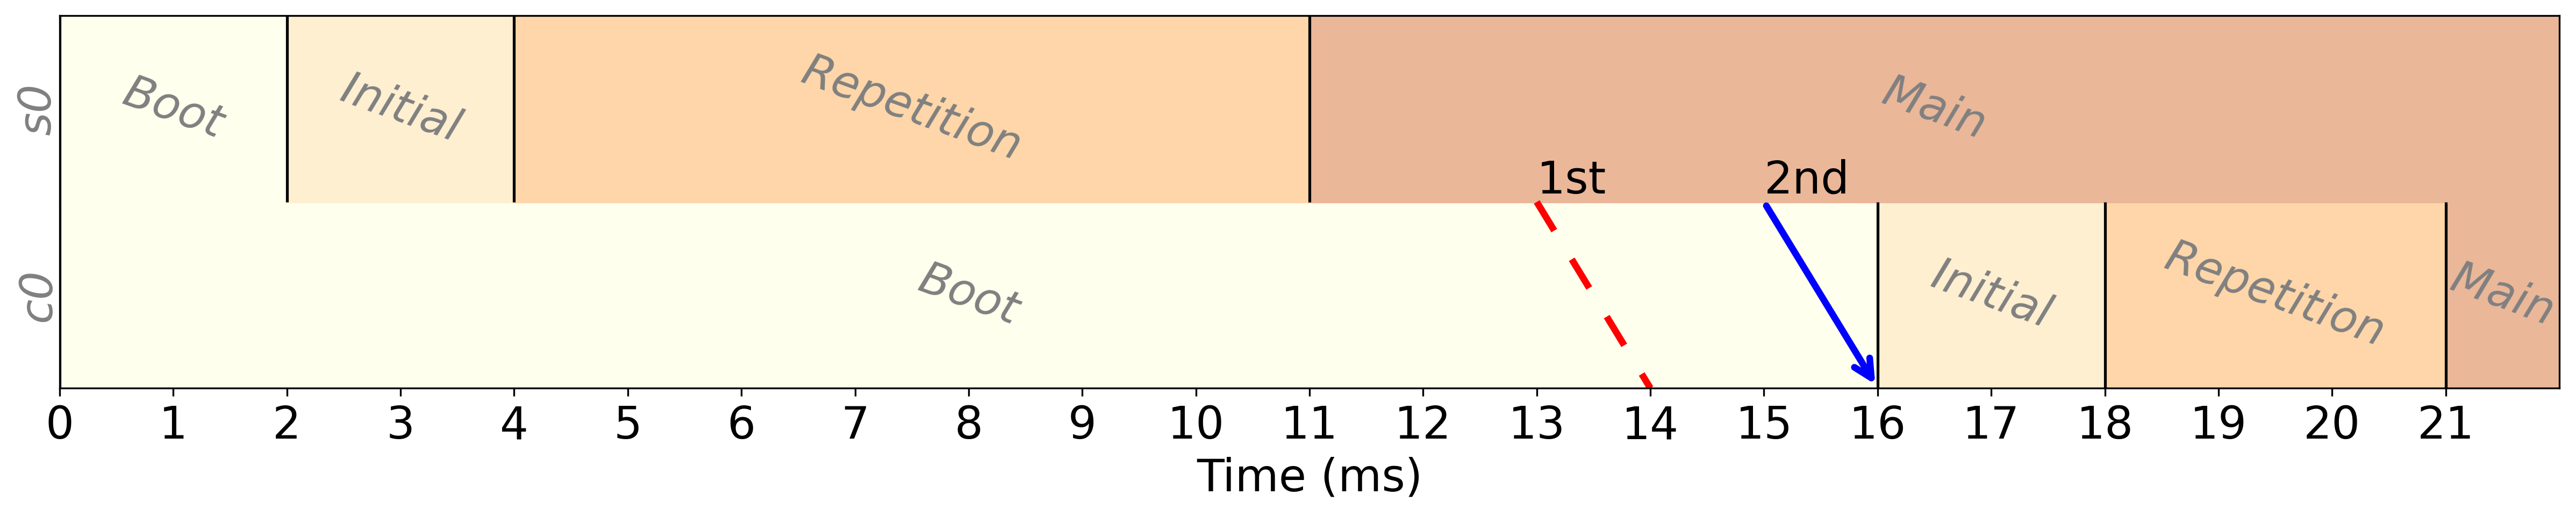

In [75]:
# Figure 1 generation code.
# Service and client configuration.
s = Service("s0", 2, 2, 1, 3, 2, 1, True)
c = Client("c0", 16, 2, 1, 2, False)
# Make a list with the entities.
entities = [c, s]
# Adjust the phases (only to improve visualization).
adjust_phases(entities)
# Communication delay.
t_c = 1
# Setup the plot.
[fig, ax] = plot_setup(entities, width=20, height=3, fontsize=20)
# Plot the phases.
plot_all_phases(ax, entities=entities, palette=light_palette)
# Plot service messages.
plot_cyc_messages(ax, s, c, t_c, plot_first=False, stop_at_first=True, send_time=False, arrival_time=False, plot_answer=False, plot_index=True)
plt.show()

#### Figure 2
Example showing *main phase* messages that either fail (red dashed line) or succeed (blue arrow) to reach the client.

Let us start by computing $y$, as the index of the first periodic message to be successfully delivered during the *main phase*:
<a id="eq12">
\begin{equation}\tag{12}
    y = \left\lceil \frac{z_c - (2^{s_{\mathit{RepMax}}} - 1) \cdot s_{\mathit{RepDel}} - \mathit{t_c}}{s_{\mathit{CycDel}}} \right\rceil .
\end{equation}
</a>
The $z_c$ tells us the size of the entire *failure window* which spans over all phases including the *main phase*; however, here we are only interested in this last one.
From that whole window we need to remove the length of the *repetition phase*, and the communication delay $\mathit{t_c}$.
What is left is the length of the *failure window* during the *main phase*.
If we divide that length by the period with which we send periodic messages, we can compute the index of the first periodic message that is successfully received by the client.

To avoid wrong estimates, we can define:
<a id="eq13">
\begin{equation}\tag{13}
    \hat{y} =
\begin{cases}
    y & \text{if } (y \geq 0) \wedge (\hat{x}_{c} \geq s_{\mathit{RepMax}})\\
    0 & \text{otherwise}
\end{cases}.
\end{equation}
</a>
Now, we can define a function that computes the timespan from the start of the *main phase* up to when the $n$-th message is sent:
<a id="eq14">
\begin{equation}\tag{14}
    t_{main}(n) = n \cdot s_{\mathit{CycDel}} .
\end{equation}
</a>

## 1.3 - Computing the discovery time for Client/Service pair
There are three main scenarios we need to consider:

 1. Service sends *offer* messages and client is silent;
 2. Service is silent and client sends *find* messages;
 3. Both service and client send messages.

We compute the discovery time for scenario (a), as follows:
<a id="eq15">
\begin{equation}\tag{15}
    t_w^{a} = s_{init} + t_{rep}(s, \hat{x}_{c}) + t_{main}(\hat{y}) + \mathit{t_c} ,
\end{equation}
</a>
which comprises the initial delay, the timespan before the first *offer* messages is successfully received (i.e., $t_{rep}(s, \hat{x}_{c})$), the same timespan for the messages during the *main phase* (i.e., $t_{main}(\hat{y})$), and the communication delay $\mathit{t_c}$.

We compute the discovery time for scenario (b), as follows:
<a id="eq16">
\begin{equation}\tag{16}
    t_w^{b} = c_{init} + t_{rep}(c, \hat{x}_{s}) + \mathit{t_c} + s_{\mathit{AnsDel}} + \mathit{t_c} ,
\end{equation}
</a>
which comprises the initial delay, the timespan before the first *find* messages is successfully received (i.e., $t_{rep}(s, \hat{x}_{s})$), the communication delay $\mathit{t_c}$ for the *find* message, the amount of time the service will wait before answering (i.e., $s_{\mathit{AnsDel}}$), and the communication delay for the answer $\mathit{t_c}$.

We compute the discovery time for scenario (c), as follows:
<a id="eq17">
\begin{equation}\tag{17}
    t_w^{c} = \min(t_w^{a}, t_w^{b}) .
\end{equation}
</a>